# Make Calibration Figures (Supplement)

Gaylen Fronk  
June 4, 2024

## Setup

In [ ]:
version <- "v6"
cv <- "nested"


In [ ]:

# packages for script
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.5      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/


Attaching package: 'probably'

The following objects are masked from 'package:base':

    as.factor, as.ordered

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")


In [ ]:
switch (Sys.info()[['sysname']],
        # PC paths
        Windows = {
          path_models <- str_c("P:/studydata/match/models/")
        },
        
        # IOS paths
        Darwin = {
          path_models <- str_c("/Volumes/private/studydata/match/models/")
        },
        
        # Linux paths
        Linux = {
          path_models <- str_c("~/mnt/private/studydata/match/models/")
        }
)


In [ ]:
# chunk defaults

options(tibble.width = Inf)
options(tibble.print_max = Inf)


## Individual Calibration Plots

Read in final model predictions (LOOCV)

In [ ]:
y_col_12 <- "pp_hybrid_wk12_outcome"
y_col_26 <- "pp_hybrid_wk26_outcome"

d_cal_12 <- read_csv(file.path(path_models, y_col_12,
                               str_c("aim_2_", version, "_", y_col_12, ".csv")),
                     show_col_types = FALSE) |> 
  glimpse()


Rows: 1,086
Columns: 11
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ tx_rct           <chr> "patch", "combo_nrt", "patch", "varenicline", "patch"…
$ tx_best          <chr> "combo_nrt", "varenicline", "combo_nrt", "varenicline…
$ tx_match         <lgl> FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, FALSE, FALSE…
$ prob_best        <dbl> 0.1860530, 0.5184533, 0.3185973, 0.4938523, 0.4883779…
$ outcome_rct_wk12 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ outcome_rct_wk4  <chr> "smoking", "smoking", "smoking", "smoking", "smoking"…
$ outcome_rct_wk26 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ prob_patch       <dbl> 0.1610573, 0.3272543, 0.2825550, 0.3491451, 0.4286955…
$ prob_combo_nrt   <dbl> 0.1860530, 0.3877443, 0.3185973, 0.4018380, 0.4309108…
$ prob_varenicline <dbl> 0.1601103, 0.5184533, 0.2743758, 0.4938523, 0.4883779…

Rows: 1,086
Columns: 11
$ subid            <dbl> 20010, 20015, 20030, 20049, 20051, 20072, 20077, 2008…
$ tx_rct           <chr> "patch", "combo_nrt", "patch", "varenicline", "patch"…
$ tx_best          <chr> "combo_nrt", "combo_nrt", "combo_nrt", "varenicline",…
$ tx_match         <lgl> FALSE, TRUE, FALSE, TRUE, FALSE, TRUE, FALSE, FALSE, …
$ prob_best        <dbl> 0.1874374, 0.2612399, 0.2328017, 0.3057146, 0.2614553…
$ outcome_rct_wk26 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ outcome_rct_wk4  <chr> "smoking", "smoking", "smoking", "smoking", "smoking"…
$ outcome_rct_wk12 <chr> "smoking", "smoking", "smoking", "abstinent", "smokin…
$ prob_patch       <dbl> 0.1445079, 0.2329569, 0.1925487, 0.2558933, 0.2404972…
$ prob_combo_nrt   <dbl> 0.1874374, 0.2612399, 0.2328017, 0.2565972, 0.2576872…
$ prob_varenicline <dbl> 0.1100380, 0.2481624, 0.1514820, 0.3057146, 0.2614553…

Set up data

In [ ]:
d_cal_12 <- d_cal_12 |> 
  mutate(.pred_abstinent = case_when(
    tx_rct == "patch" ~ prob_patch,
    tx_rct == "combo_nrt" ~ prob_combo_nrt,
    tx_rct == "varenicline" ~ prob_varenicline,
    TRUE ~ NA_real_
  )) |> 
  select(outcome_rct = outcome_rct_wk12, .pred_abstinent) |> 
  mutate(outcome_rct = factor(outcome_rct,
                              levels = c("abstinent", "smoking"))) |> 
  glimpse()


Rows: 1,086
Columns: 2
$ outcome_rct     <fct> smoking, smoking, smoking, abstinent, smoking, smoking…
$ .pred_abstinent <dbl> 0.1610573, 0.3877443, 0.2825550, 0.4938523, 0.4286955,…

Rows: 1,086
Columns: 2
$ outcome_rct     <fct> smoking, smoking, smoking, abstinent, smoking, smoking…
$ .pred_abstinent <dbl> 0.1445079, 0.2612399, 0.1925487, 0.3057146, 0.2404972,…

Created binned plot week 12

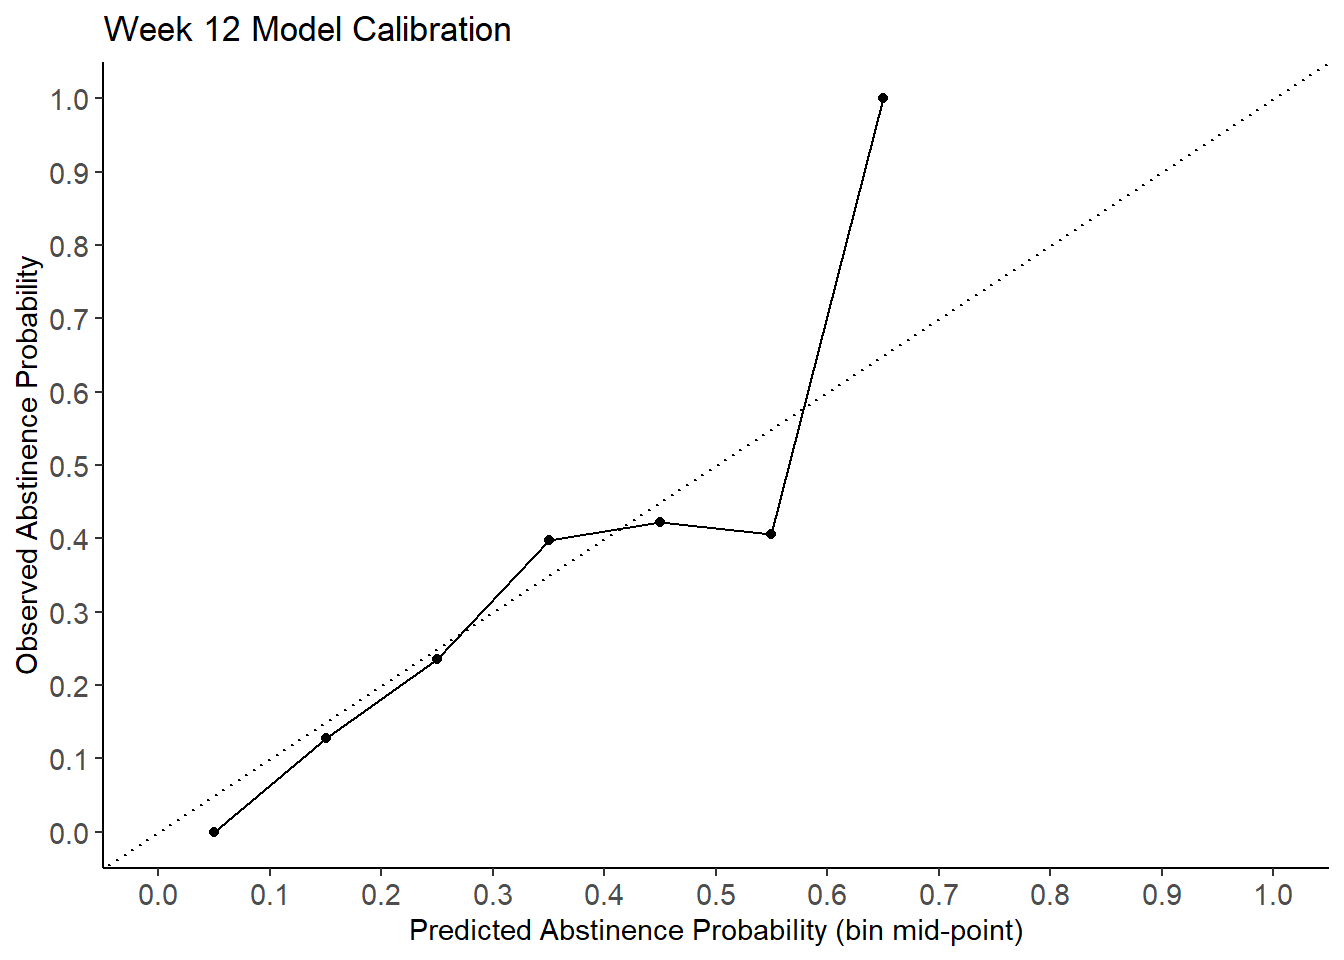

In [ ]:

bin_width = 0.10

fig_cal_bins_12 <- d_cal_12 |> 
  rename(prob_raw = .pred_abstinent) |> 
  mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)),
         abstinent = if_else(outcome_rct == "abstinent", 1, 0)) |> 
  group_by(bins)  |> 
  summarize(mean_abstinent = mean(abstinent),
            .groups = "drop") |>
  mutate(bins = as.numeric(bins),
         midpoints = bin_width/2 + bin_width * (bins - 1))  |> 
  ggplot(data = _, aes(x = midpoints, y = mean_abstinent)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  geom_line() +
  geom_point() +
  labs(
    x = "Predicted Abstinence Probability (bin mid-point)",
    y = "Observed Abstinence Probability",
    title = "Week 12 Model Calibration") +
  scale_x_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  theme(axis.text = element_text(size = rel(1)),
        axis.title = element_text(size = rel(1)))

fig_cal_bins_12


Created binned plot week 26

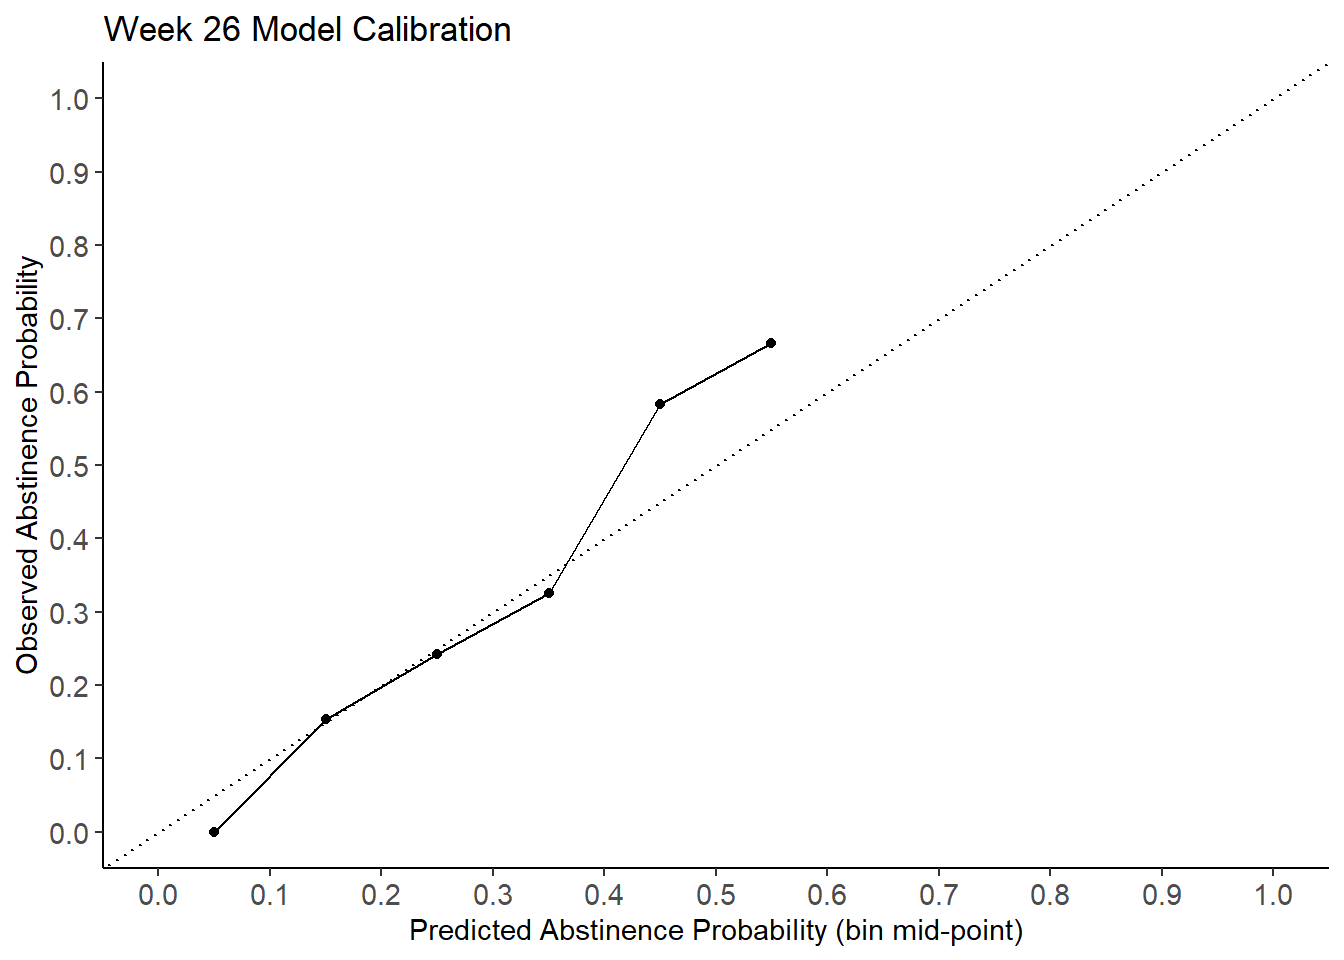

In [ ]:

bin_width = 0.10

fig_cal_bins_26 <- d_cal_26 |> 
  rename(prob_raw = .pred_abstinent) |> 
  mutate(bins = cut(prob_raw, breaks = seq(0, 1, bin_width)),
         abstinent = if_else(outcome_rct == "abstinent", 1, 0)) |> 
  group_by(bins)  |> 
  summarize(mean_abstinent = mean(abstinent),
            .groups = "drop") |>
  mutate(bins = as.numeric(bins),
         midpoints = bin_width/2 + bin_width * (bins - 1))  |> 
  ggplot(data = _, aes(x = midpoints, y = mean_abstinent)) +
  geom_abline(slope = 1, intercept = 0, linetype = "dotted") +
  geom_line() +
  geom_point() +
  labs(
    x = "Predicted Abstinence Probability (bin mid-point)",
    y = "Observed Abstinence Probability",
    title = "Week 26 Model Calibration") +
  scale_x_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  scale_y_continuous(breaks = seq(0, 1, bin_width),
                     limits = c(0, 1)) +
  theme(axis.text = element_text(size = rel(1)),
        axis.title = element_text(size = rel(1)))

fig_cal_bins_26


## Combine plots into paneled figure

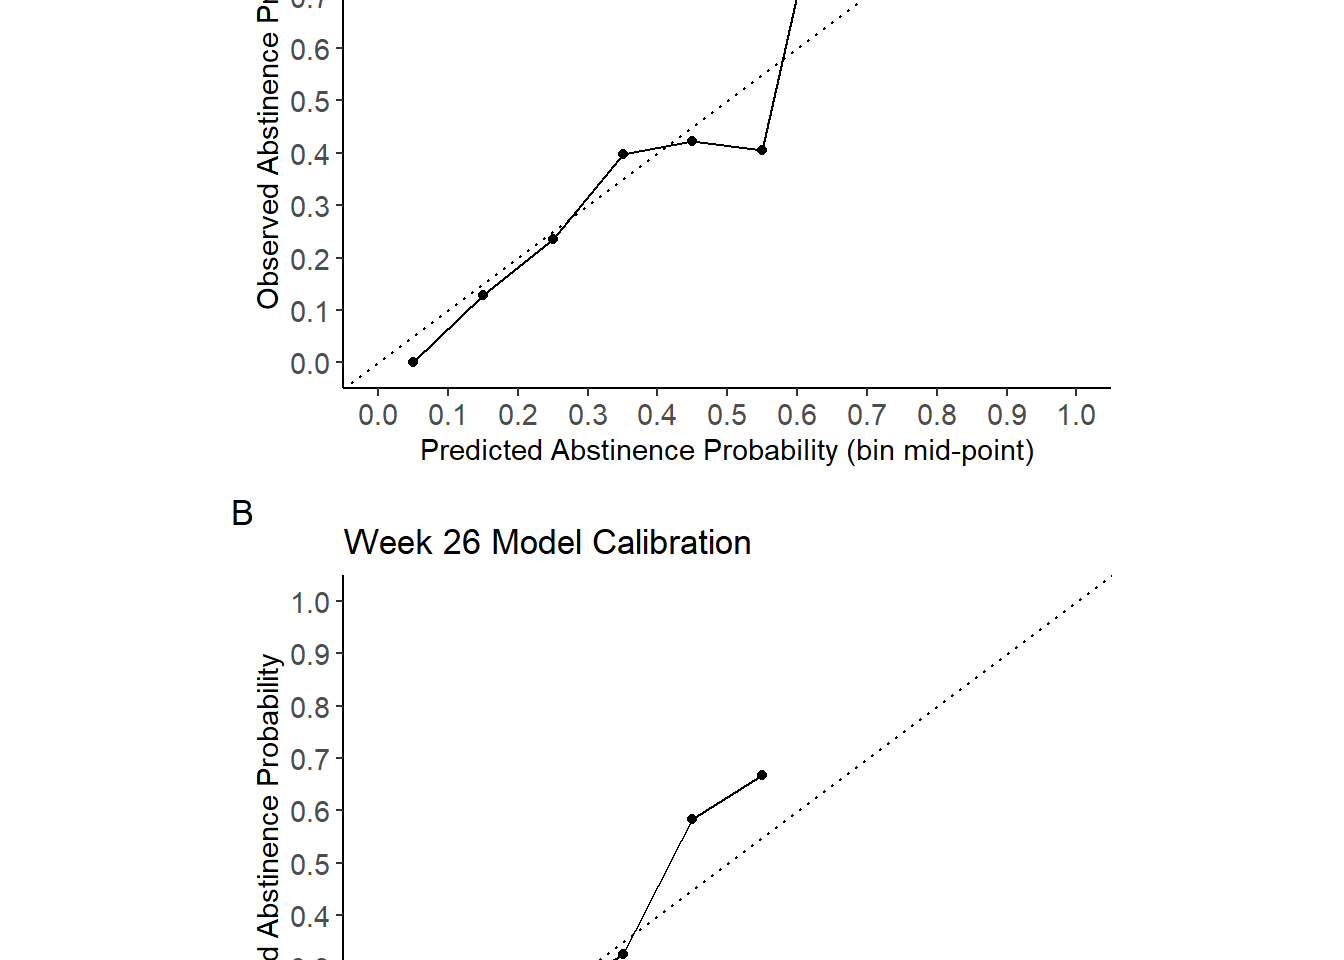

In [ ]:

fig_cal_supp <- (fig_cal_bins_12 / fig_cal_bins_26) +
  plot_layout(ncol = 1,
              heights = unit(c(3, 3), "in"),
              widths = unit(c(4, 4), "in")) +
  plot_annotation(tag_levels = "A")

fig_cal_supp
